In [104]:
#Importing all relevant libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

None

# Dataset Cleaning and Preprocessing

In [77]:
data = pd.read_excel('DATASET.xlsx', sheet_name='Dataset')
data.tail(3)

,CSD,Metal Type,Density (g/cm3),PLD,LCD,VSA (m2/cm3),GSA (m2/g),void fraction,pore volume (cm3/g),Note,Extension,65bar_298Kelvin
4760,ZUQVOW,"Cr, Na",0.928375,3.64428,5.72998,0.00,0.000,0.572886,0.752649,NaN,charged,173.972685
4761,ZURQOS,"Cd, Ni",1.306180,3.68876,4.62363,0.00,0.000,0.416831,0.409695,NaN,clean,144.184972
4762,ZURROT,"Cd, Ni",1.077750,3.92110,4.90807,1002.98,930.633,0.452553,0.567345,NaN,clean,138.541367


In [78]:
data.shape

(4763, 12)

List of NOT relevant columns:

CSD - Reference code for the structure of MOFs. <br>
Note - Very high number of NaN values. <br>
Extension - Cleaning procedure used for structures to calculate features. Relevant for dataset development, irrelevant for dataset training.

In [79]:
dataset = data.drop(['Note','Extension','CSD'], axis=1)
dataset.tail(3)

,Metal Type,Density (g/cm3),PLD,LCD,VSA (m2/cm3),GSA (m2/g),void fraction,pore volume (cm3/g),65bar_298Kelvin
4760,"Cr, Na",0.928375,3.64428,5.72998,0.00,0.000,0.572886,0.752649,173.972685
4761,"Cd, Ni",1.306180,3.68876,4.62363,0.00,0.000,0.416831,0.409695,144.184972
4762,"Cd, Ni",1.077750,3.92110,4.90807,1002.98,930.633,0.452553,0.567345,138.541367


In [80]:
dataset.shape

(4763, 9)

In [81]:
dataset.isna().sum() 

Metal Type             0
Density (g/cm3)        0
PLD                    0
LCD                    0
VSA  (m2/cm3)          0
GSA (m2/g)             0
void fraction          0
pore volume (cm3/g)    0
65bar_298Kelvin        0
dtype: int64

No missing values.

Need to convert string columns into numerical columns by performing one hot encoding. 

In [82]:
split_values = dataset['Metal Type'].str.split(', ')
unique_values = set([val for sublist in split_values.dropna() for val in sublist])
one_hot_df = pd.DataFrame(0, index=dataset.index, columns=unique_values)
for idx, row in split_values.dropna().iteritems():
    one_hot_df.loc[idx, row] = 1

df = pd.concat([dataset.drop(columns=['Metal Type']), one_hot_df], axis=1)

In [83]:
pd.set_option('display.max_columns', None)
df.tail(3)

,Density (g/cm3),PLD,LCD,VSA (m2/cm3),GSA (m2/g),void fraction,pore volume (cm3/g),65bar_298Kelvin,V,Zr,Cs,Sr,Se,Np,Rb,Sc,Ti,Lu,Ag,Nd,Mg,Ga,Cr,Co,Tm,Rh,Pr,Bi,Eu,Ho,Ge,Pt,Gd,W,Dy,Fe,Mo,Ru,Pu,Ir,Pd,Au,Te,Nb,Zn,Er,Sn,Tb,Ni,Hf,Cd,Ba,In,Y,B,Sb,Re,Hg,Ce,Na,Li,Ca,Cu,Yb,U,As,Be,Si,Mn,Al,La,Sm,Pb,Th,K
4760,0.928375,3.64428,5.72998,0.00,0.000,0.572886,0.752649,173.972685,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4761,1.306180,3.68876,4.62363,0.00,0.000,0.416831,0.409695,144.184972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4762,1.077750,3.92110,4.90807,1002.98,930.633,0.452553,0.567345,138.541367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
df.shape

(4763, 75)

Since this is increasing the number of features to 75, feature selection will be done to remove all these.

# Data Analysis

In [85]:
dataanalysisset = dataset.drop(['Metal Type'], axis=1)

In [86]:
zeros = (dataanalysisset == 0).sum()
print("Number of zeros in each column:")
print(zeros)

Number of zeros in each column:
Density (g/cm3)           0
PLD                       0
LCD                       0
VSA  (m2/cm3)          1899
GSA (m2/g)             1899
void fraction             0
pore volume (cm3/g)       0
65bar_298Kelvin          26
dtype: int64


Many VSA and GSA values are 0. <br>
They are also zero in the original documents. <br>
Feature selection will be done by dropping the columns or not.

In [87]:
df.describe()

,Density (g/cm3),PLD,LCD,VSA (m2/cm3),GSA (m2/g),void fraction,pore volume (cm3/g),65bar_298Kelvin,V,Zr,Cs,Sr,Se,Np,Rb,Sc,Ti,Lu,Ag,Nd,Mg,Ga,Cr,Co,Tm,Rh,Pr,Bi,Eu,Ho,Ge,Pt,Gd,W,Dy,Fe,Mo,Ru,Pu,Ir,Pd,Au,Te,Nb,Zn,Er,Sn,Tb,Ni,Hf,Cd,Ba,In,Y,B,Sb,Re,Hg,Ce,Na,Li,Ca,Cu,Yb,U,As,Be,Si,Mn,Al,La,Sm,Pb,Th,K
count,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.00000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.00000,4763.00000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000
mean,1.377527,4.816225,6.764104,758.717795,826.226905,0.423626,0.492469,127.723100,0.011127,0.005039,0.002309,0.007558,0.001050,0.00084,0.001680,0.003359,0.002519,0.002309,0.035272,0.025404,0.014907,0.006299,0.007558,0.108965,0.004409,0.000630,0.015746,0.001260,0.029603,0.007348,0.001050,0.001680,0.025404,0.011337,0.016796,0.029813,0.011757,0.003359,0.00021,0.00021,0.001470,0.001680,0.001050,0.002100,0.192946,0.015117,0.001050,0.020365,0.046399,0.001260,0.105606,0.008398,0.016586,0.007978,0.003569,0.000630,0.002309,0.001680,0.014487,0.015536,0.004619,0.012807,0.150955,0.009238,0.009868,0.000630,0.000420,0.007558,0.064035,0.008608,0.026454,0.014067,0.002100,0.001260,0.010917
std,0.501595,2.866822,3.864997,760.699108,1079.345669,0.207481,0.398293,62.856841,0.104909,0.070813,0.048006,0.086618,0.032386,0.02897,0.040953,0.057867,0.050136,0.048006,0.184486,0.157366,0.121192,0.079121,0.086618,0.311628,0.066261,0.025092,0.124506,0.035474,0.169508,0.085416,0.032386,0.040953,0.157366,0.105883,0.128520,0.170089,0.107803,0.057867,0.01449,0.01449,0.038312,0.040953,0.032386,0.045777,0.394652,0.122029,0.032386,0.141261,0.210370,0.035474,0.307365,0.091265,0.127728,0.088973,0.059642,0.025092,0.048006,0.040953,0.119498,0.123686,0.067813,0.112453,0.358043,0.095679,0.098856,0.025092,0.020489,0.086618,0.244841,0.092389,0.160498,0.117779,0.045777,0.035474,0.103926
min,0.126526,2.400040,2.532560,0.000000,0.000000,0.001113,0.071825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.047870,3.187355,4.619935,0.000000,0.000000,0.257142,0.272397,83.608388,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.312640,4.047830,5.567650,629.801000,428.343000,0.404773,0.388375,127.194252,0.0

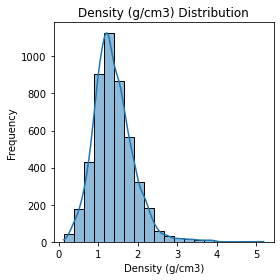

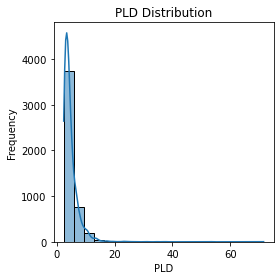

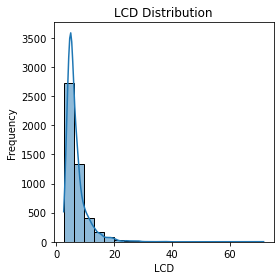

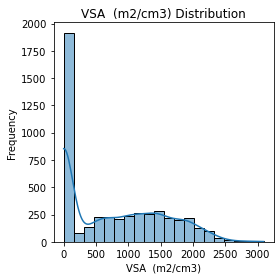

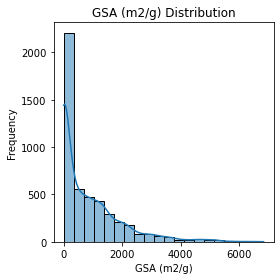

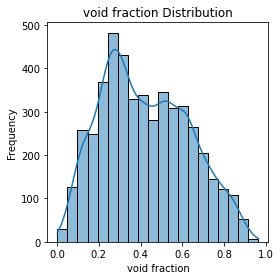

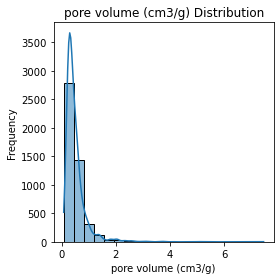

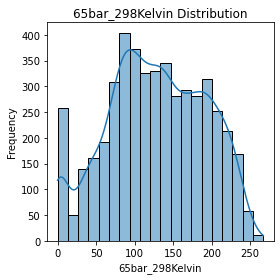

In [88]:
for feature in dataanalysisset.columns:
    plt.figure(figsize=(4,4))
    sns.histplot(df[feature], bins=20, kde=True)
    plt.title(f"{feature} Distribution")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

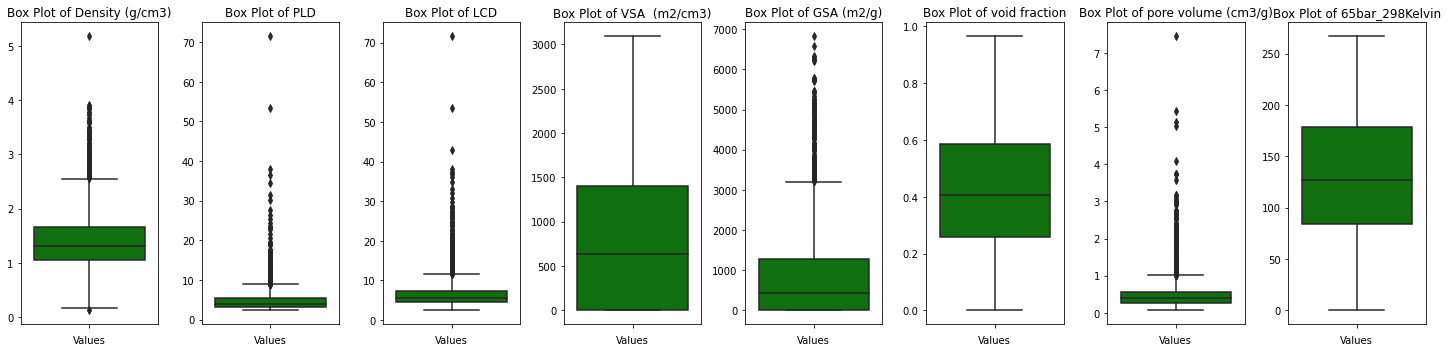

In [89]:
fig, axes = plt.subplots(figsize=(20, 5), ncols=8)

for i, col in enumerate(dataanalysisset):
    sns.boxplot(y=dataanalysisset[col], ax=axes[i], color='green')  # Removed x='Values' parameter
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

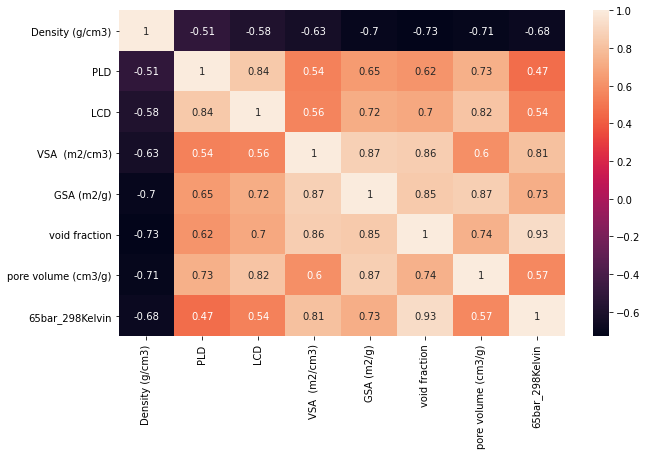

In [90]:
hmdata = dataanalysisset.corr()
plt.figure(figsize=(10,6))
sns.heatmap(hmdata, annot=True)
plt.show()

Density has negative correlation with every feature while all others have positive correlation. <br>
Target has strong positive correlation with void fraction.

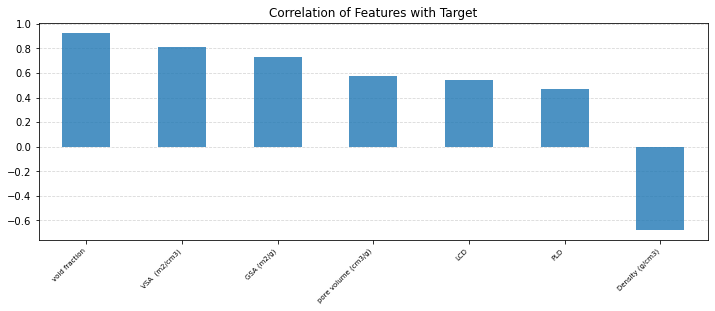

In [103]:
(dataanalysisset.drop('65bar_298Kelvin', axis=1)  
   .corrwith(dataanalysisset['65bar_298Kelvin'])
   .sort_values(ascending=False) 
   .plot(kind='bar',  
         figsize=(12, 4),  
         title="Correlation of Features with Target",  
         alpha=0.8, 
         zorder=3)  
)

plt.grid(axis='y', linestyle='--', alpha=.5)
plt.xticks(rotation=45, ha='right', size=7)
plt.show()

# Model Training

Using a Random Forest Regressor.

## Generating Training, Validation and Testing Sets

In [105]:
X = df.drop(['65bar_298Kelvin'], axis=1)
y = df[['65bar_298Kelvin']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Training the Model

In [106]:
rfr = RandomForestRegressor(random_state=14)
rfr.fit(X_train, y_train)
y_val_pred = rfr.predict(X_val)
y_test_pred = rfr.predict(X_test)

<ipython-input-106-ec9b0fbdfc2d>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


## Evaluating the Model

In [23]:
print("Validation Set Mean Absolute Error:", mean_absolute_error(y_val, y_val_pred))
print("Validation Set Mean Squared Error:", mean_squared_error(y_val, y_val_pred))
print("Validation Set R-squared Score:", r2_score(y_val, y_val_pred))
print()
print("Test Set Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Test Set Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("Test Set R-squared Score:", r2_score(y_test, y_test_pred))

Validation Set Mean Absolute Error: 0.17598893432013718
Validation Set Mean Squared Error: 0.06938200527566075
Validation Set R-squared Score: 0.9290032214117425

Test Set Mean Absolute Error: 0.16797974081508107
Test Set Mean Squared Error: 0.06172275876999027
Test Set R-squared Score: 0.9405915283956441


## Hyperparameter Tuning

Baseline model gives an accuracy of 94%. <br>
Let's perform hyperparameter tuning using GridSearchCV( ) to try and increase it.

In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/avani/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=14), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=1)

In [42]:
best_estimator = grid_search.best_estimator_
test_score = best_estimator.score(X_test, y_test)
print("Best Estimator:", grid_search.best_params_)
print("Test R-squared Score:", best_estimator.score(X_test, y_test))

Best Estimator: {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Test R-squared Score: 0.9377347587631673


As the accuracy went down from 94% to 93.77%, hyperparameter tuning **did not yield a better result** than the baseline model.

## Model Training with Feature Selection

Removing GSA and VSA.

In [33]:
X = df.drop(['VSA  (m2/cm3)', 'GSA (m2/g)', '65bar_298Kelvin'], axis=1)
y = df[['65bar_298Kelvin']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(random_state=14)
rfr.fit(X_train, y_train)
y_val_pred = rfr.predict(X_val)
y_test_pred = rfr.predict(X_test)

print("Validation Set Mean Absolute Error:", mean_absolute_error(y_val, y_val_pred))
print("Validation Set Mean Squared Error:", mean_squared_error(y_val, y_val_pred))
print("Validation Set R-squared Score:", r2_score(y_val, y_val_pred))
print()
print("Test Set Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Test Set Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("Test Set R-squared Score:", r2_score(y_test, y_test_pred))

<ipython-input-33-c515a6c3bc74>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


Validation Set Mean Absolute Error: 0.1800880087554795
Validation Set Mean Squared Error: 0.07191281366357925
Validation Set R-squared Score: 0.9264135118458042

Test Set Mean Absolute Error: 0.1725390265198079
Test Set Mean Squared Error: 0.06450542092035387
Test Set R-squared Score: 0.9379132018166194


In [44]:
X = dataset.drop(['Metal Type', '65bar_298Kelvin'], axis=1)
y = df[['65bar_298Kelvin']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(random_state=14)
rfr.fit(X_train, y_train)
y_val_pred = rfr.predict(X_val)
y_test_pred = rfr.predict(X_test)

print("Validation Set Mean Absolute Error:", mean_absolute_error(y_val, y_val_pred))
print("Validation Set Mean Squared Error:", mean_squared_error(y_val, y_val_pred))
print("Validation Set R-squared Score:", r2_score(y_val, y_val_pred))
print()
print("Test Set Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Test Set Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("Test Set R-squared Score:", r2_score(y_test, y_test_pred))

<ipython-input-44-d20d3a7f644a>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


Validation Set Mean Absolute Error: 0.17808979125931174
Validation Set Mean Squared Error: 0.07050010011079394
Validation Set R-squared Score: 0.9278591044157687

Test Set Mean Absolute Error: 0.16993586498031263
Test Set Mean Squared Error: 0.061971889958689595
Test Set R-squared Score: 0.9403517383498887


As the accuracy went down, feature selection **did not yield a better result** than the baseline model.

## Post Training Data Analysis

This graph is for baseline model.

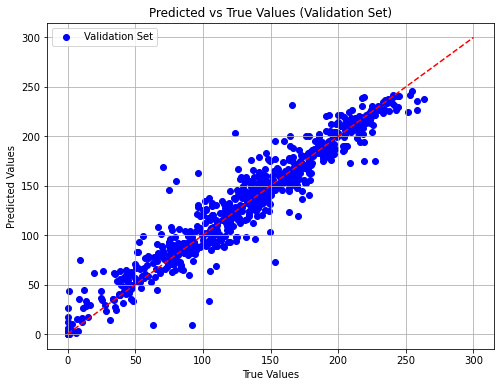

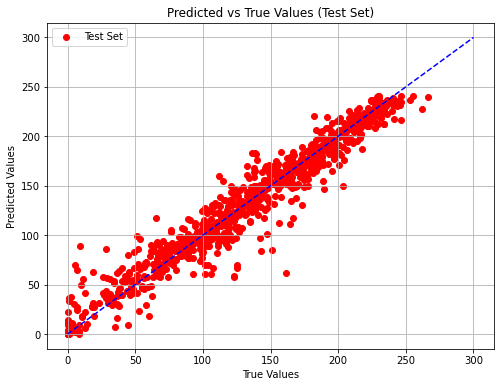

In [47]:
y_val_pred_inv = scaler_y.inverse_transform(y_val_pred)
y_val_inv = scaler_y.inverse_transform(y_val)

y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_val_inv, y_val_pred_inv, color='blue', label='Validation Set')
plt.plot([0, 300], [0, 300], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test_inv, y_test_pred_inv, color='red', label='Test Set')
plt.plot([0, 300], [0, 300], color='blue', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

In [94]:
importances = rfr.feature_importances_
feature_names = X.columns
sorted_indices = importances.argsort()[::-1]
for feature, importance in zip(feature_names[sorted_indices], importances[sorted_indices]):
    print(f"{feature}: {importance:.3f}")

void fraction: 0.896
LCD: 0.045
PLD: 0.018
VSA  (m2/cm3): 0.009
Density (g/cm3): 0.008
pore volume (cm3/g): 0.007
GSA (m2/g): 0.003
Mo: 0.001
Cu: 0.001
Ag: 0.001
Ni: 0.001
Zn: 0.001
Cd: 0.001
Er: 0.001
Co: 0.001
Mn: 0.001
V: 0.001
La: 0.000
Si: 0.000
Fe: 0.000
In: 0.000
Al: 0.000
Ca: 0.000
Cr: 0.000
Tb: 0.000
Zr: 0.000
Ba: 0.000
W: 0.000
Na: 0.000
Pb: 0.000
Nd: 0.000
Y: 0.000
Ce: 0.000
Pr: 0.000
Sc: 0.000
Eu: 0.000
K: 0.000
Dy: 0.000
U: 0.000
Ga: 0.000
Mg: 0.000
Li: 0.000
Gd: 0.000
Yb: 0.000
Np: 0.000
Ru: 0.000
Sr: 0.000
Sb: 0.000
Bi: 0.000
Sm: 0.000
Pt: 0.000
Tm: 0.000
Ho: 0.000
Re: 0.000
Sn: 0.000
Te: 0.000
Hg: 0.000
Cs: 0.000
Lu: 0.000
Nb: 0.000
B: 0.000
Th: 0.000
Rb: 0.000
Hf: 0.000
Be: 0.000
Ti: 0.000
Au: 0.000
Rh: 0.000
Ge: 0.000
Se: 0.000
Pd: 0.000
As: 0.000
Pu: 0.000
Ir: 0.000
